# 0. Imports and functions definitions

In [1]:
import uproot, os
import numpy             as np
import matplotlib.pyplot as plt

In [76]:
# def extract_branches(folder,root_file,sensors,branches={"Photons":["fX","fY","fZ","fPhi","fTheta","fsensor"],"Hits":["fsensor","acumHits"]}):
def extract_branches(folder,root_file,sensors,branches={"Photons":["fX","fY","fZ","fPhi","fTheta"],"Hits":["fsensor"]},debug=False):
    opened_file = uproot.open(folder+root_file)
    branch_dict = dict.fromkeys(branches.keys());
    my_data = dict.fromkeys([root_file]); my_data[root_file] = dict.fromkeys(sensors)
    for k,key in enumerate(branch_dict):
        branch_dict[key] = {}
        for branch in branches[key]: 
            branch_dict[key][branch] = opened_file[key][branch].array().to_numpy();
    for s,sensor in enumerate(sensors):
        my_data[root_file][sensor] = {}
        for k,key in enumerate(branch_dict):
            for branch in branches[key]: 
                my_data[root_file][sensor][branch] = branch_dict[key][branch][branch_dict["Hits"]["fsensor"]==s]
    if debug: print(my_data)
    return my_data

def compute_real_angles(my_data,sensors_info,debug=False):
    for geo_file in my_data.keys():
        for sensor in my_data[geo_file].keys():
            phi   = my_data[geo_file][sensor]["fPhi"]
            theta = my_data[geo_file][sensor]["fTheta"]
            
            abs_vec = np.array([ np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
            norm    = np.sum(  (abs_vec.T*sensors_info[sensor][geo_file]),axis=1 )
            inc_ang = np.arccos(norm)
            
            my_data[geo_file][sensor]["vector"]        = abs_vec
            my_data[geo_file][sensor]["norm"]          = norm
            my_data[geo_file][sensor]["inc_ang"]       = inc_ang
            if   ((np.mean(inc_ang)>np.pi/2)):my_data[geo_file][sensor]["inc_ang_fixed"] = np.pi - inc_ang
            else                             :my_data[geo_file][sensor]["inc_ang_fixed"] = inc_ang
    if debug: print(sensors_info)
    return my_data

def plot_angular_distributions(my_data,dpi=50):
    fig = plt.figure(dpi=dpi)
    for my_file in my_data.keys():
        plt.title(my_file.replace(".root",""))
        for sensor in my_data[my_file]: 
            plt.hist (my_data[my_file][sensor]["inc_ang_fixed"]*180/np.pi,45,[0,90],alpha=.5,density=True,label=sensor)
        plt.xlabel("Incident angle (°)")
        plt.legend()
        plt.show()
    return fig
    

def plot_photon_density(my_data,sensors_info,dpi=50):
    axes   = ["fX","fY","fZ"]
    labels = ["X axis", "Y axis", "Z axis"]
    fig = plt.figure(dpi=dpi)
    for my_file in my_data:
        for sensor in my_data[my_file]: 
            plt.figure()
            plt.title(my_file.replace(".root","_")+sensor)
            axes2plot = list((sensors_info[sensor][my_file]-1)*(-1))
            plt.hist2d(my_data[my_file][sensor][axes[axes2plot[0]]],my_data[my_file][sensor][axes[axes2plot[1]]])
            plt.xlabel(labels[axes2plot[0]])
            plt.ylabel(labels[axes2plot[1]])
            plt.colorbar()
            plt.show()
    return fig

def plot_acumhits(my_data,dpi=50):
    for my_file in my_data:
        fig = plt.figure(dpi=dpi)
        plt.title(my_file.replace(".root",""))
        for sensor in my_data[my_file]: 
                plt.hist (my_data[my_file][sensor]["acumHits"], 35,alpha=0.5,histtype="step",label=sensor)
        plt.legend()
        plt.show()
    return fig

### Define your variables

In [48]:
folder    = "../data/"
sensors   = ["Arapuca","SiPM1","SiPM2"]
contenido = ["output.root"]
debug     = False

In [26]:
for my_file in contenido:
    my_data = extract_branches(folder=folder,root_file=my_file,sensors=sensors,debug=debug)

{'output.root': {'Arapuca': {'fX': array([ 60.31776584,   0.11260768,  11.00930078,  29.89544668,
         9.60431871,  -6.91470294,  18.55595039,  -6.45306185,
         5.58416687, -22.28113039,  29.65018403,   3.77656215,
       -70.25481778,  40.94204714, -42.26022061, -32.33990676,
       -14.7227522 ,  20.16941037,  66.66041574,  25.97912556,
        55.86573113,  27.4609579 , -22.57712145,  10.36906623,
        49.30642198,  23.79411334]), 'fY': array([0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51,
       0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51,
       0.51, 0.51, 0.51, 0.51]), 'fZ': array([  1.9743861 ,  -5.75662234, -22.72107411,  -7.84883329,
        29.58981246,  13.75222988,  31.80500797,   5.34192787,
       -53.35439558,  -8.16707364,  69.62454837,  15.18321646,
        -5.10952471, -70.45472575,  40.89557931,  48.18332996,
        16.4422311 ,  67.53827215, -65.59900242,  40.59693817,
         5.98782692, -10.75863691, -12.88877

### DEFINE YOUR GEOMETRY
* Unitary vectors
* Sensors dimensions

In [52]:
# Add unitary vectors
sensors_info=dict(); #area and unitary vectors for each configuration file
for sensor in sensors:
    sensors_info[sensor]={};
    for my_file in contenido:
        sensors_info[sensor][my_file]={}
        if (sensor=="Arapuca"): sensors_info[sensor][my_file]=np.array([ 0, 1, 0])
        if (sensor=="SiPM1"):   sensors_info[sensor][my_file]=np.array([ 1, 0, 0])
        if (sensor=="SiPM2"):   sensors_info[sensor][my_file]=np.array([-1, 0, 0])

sensors_info["Arapuca"]["Area"] = 143.75*143.75 #mm**2
sensors_info["SiPM1"]["Area"]   = 6*6           #mm**2
sensors_info["SiPM2"]["Area"]   = 6*6           #mm**2

my_data = compute_real_angles(my_data=my_data,sensors_info=sensors_info,debug=debug)

/afs/ciemat.es/user/p/perezl/Analysis_Laura/python3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/afs/ciemat.es/user/p/perezl/Analysis_Laura/python3.7/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [69]:
list((sensors_info["Arapuca"]["output.root"]-1)*(-1))

[1, 0, 1]

/afs/ciemat.es/user/p/perezl/Analysis_Laura/python3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


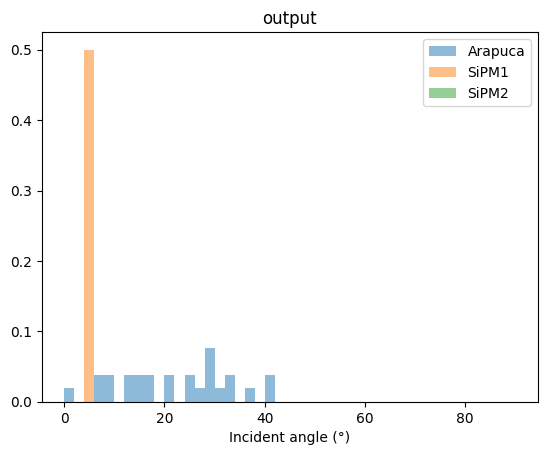

In [38]:
fig_ang = plot_angular_distributions(my_data,dpi=100)

<Figure size 320x240 with 0 Axes>

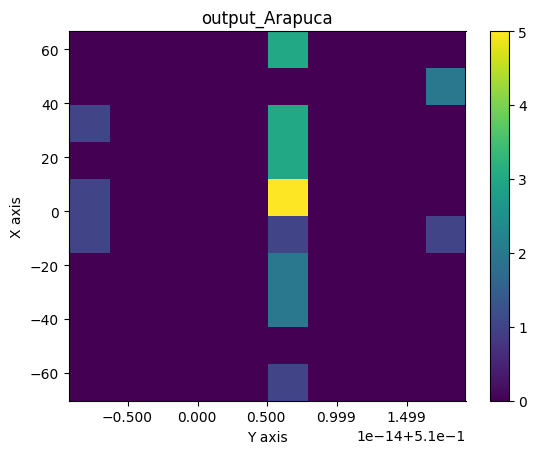

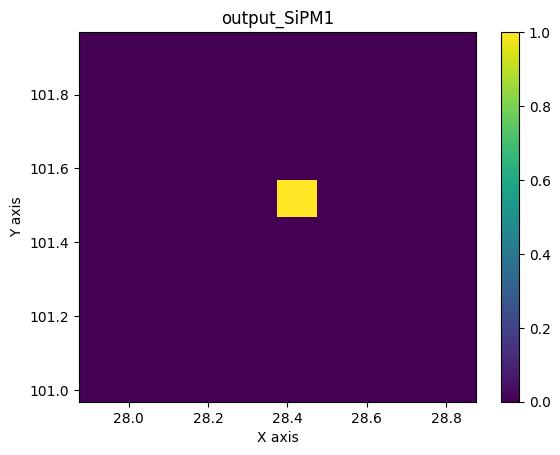

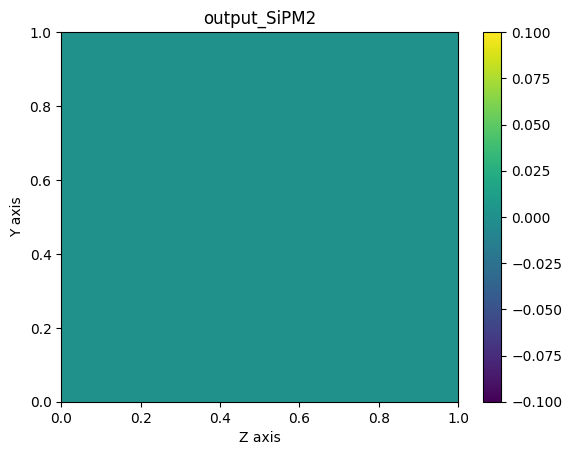

In [74]:
fig_ph = plot_photon_density(my_data,sensors_info,dpi=50)

KeyError: 'acumHits'

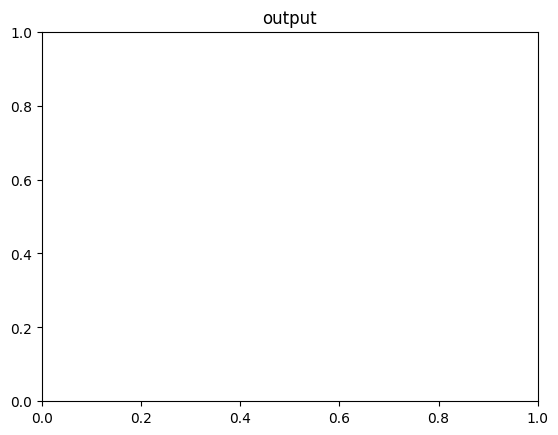

In [43]:
fig_acum = plot_acumhits(my_data,dpi=100)
